<a href="https://colab.research.google.com/github/rubincus/OptimizacionPuentes/blob/master/PrediccionFuncionObjetivoPuentesFactibles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sqlite3
import pandas as pd 
import os


In [ ]:
# Esta ruta debe actualizarse en dode se encuentren las base de datos.
con = sqlite3.connect('G:/Investigación/puentes/No_Factibles/puentes_no_factibles_db2.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('esfuerzos',), ('deformaciones',), ('mediciones_coeficientes',)]


In [ ]:
"""
Esta función tiene por objetivo leer todos los archivos .db 
y cargarlos en un unico dataframe de pandas. 
Utilizaremos algunas funcionalidades de os y pandas
"""

def read_db_files(path, file_type):

    file_names = [x for x in os.listdir(path) if x.endswith(file_type)]
    state = 0
    for file_name in file_names:
        con = sqlite3.connect(path + file_name)
        if state == 0:
            bridges = pd.read_sql_query("SELECT * from mediciones_coeficientes", con)
            #print(bridges.shape)
            state = 1
        else:
            print(file_name)
            bridges_temp = pd.read_sql_query("SELECT * from mediciones_coeficientes", con)
            #print(bridges_temp.shape)
            # merge
            bridges = pd.concat([bridges, bridges_temp])
    return bridges
            
        

In [ ]:
"""
Vamos a cargar solo los puentes factibles ya que vamos 
a asumir que primero miramos la factibilidad a través 
de un modelo o calculandola.
"""

path = 'G:/Investigación/puentes/Factibles/'
file_type = 'db'
bridges = read_db_files(path, file_type)


puentes_aleatorios_db10.db
puentes_aleatorios_db11.db
puentes_aleatorios_db12.db
puentes_aleatorios_db13.db
puentes_aleatorios_db14.db
puentes_aleatorios_db15.db
puentes_aleatorios_db16.db
puentes_aleatorios_db2.db
puentes_aleatorios_db3.db
puentes_aleatorios_db4.db
puentes_aleatorios_db5.db
puentes_aleatorios_db6.db
puentes_aleatorios_db7.db
puentes_aleatorios_db8.db
puentes_aleatorios_db9.db


In [ ]:
# Aquí estamos filtrando las primeras 35 variables que representan la configuración del puente.
X_bridges = bridges.iloc[:,1:36]
# Aquí cargamos las variables dependientes.
Y_bridges = bridges[['Coste','CO2','Energia']]
Y_bridges.head()

,Coste,CO2,Energia
0,5047563.78107136,11481558.822327,32799711.8113857
1,5101377.68775604,10669709.9912148,30518979.986918
2,5059411.08573801,11115080.3588463,31799316.647336
3,4999161.03571363,10615117.2720903,30696540.8189551
4,6193226.46337902,13118491.5941369,37268592.85006


### Ahora vamos a normalizar y separar la data.

Aplicamos una normalización minmaxscaler, lo cual funciona bien para variables que estan uniformememnte distribuidas y no tienen outliers.

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler1 = MinMaxScaler()
X_bridges_scaled = scaler.fit_transform(X_bridges)
Y_bridges_scaled = scaler1.fit_transform(Y_bridges)

In [ ]:
# Utilizamos un 33% para testear el resultado. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bridges_scaled, Y_bridges_scaled, test_size=0.33, random_state=20)


### Aquí construimos nuestro modelo

In [ ]:
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [ ]:
# Incorpore su capa de entrada
input_layer = Input(shape=(35,), dtype='float32')

In [ ]:
# Incorpore capas escondidas
dense1 = Dense(128, activation='relu')(input_layer)
dense2 = Dense(64, activation='tanh')(dense1)
dense3 = Dense(32, activation='tanh')(dense2)

In [ ]:
# Agregue su dropout
dropout_layer = Dropout(0.2)(dense3)

In [ ]:
# Ingrese su capa de salida
output_layer = Dense(3, activation='linear')(dropout_layer)

In [ ]:
# Compile su modelo aqui.
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')
ts_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 35)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               4608      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 15,043
Trainable params: 15,043
Non-trainable params: 0
__________________________________________________

In [ ]:
save_weights_at = os.path.join(path, 'Bridge_MLP_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_test, y_test),
             shuffle=True)

Epoch 1/20
849/849 [==============================] - 1s 866us/step - loss: 0.0901 - val_loss: 0.0319
Epoch 2/20
849/849 [==============================] - 1s 692us/step - loss: 0.0467 - val_loss: 0.0263
Epoch 3/20
849/849 [==============================] - 1s 704us/step - loss: 0.0339 - val_loss: 0.0151
Epoch 4/20
849/849 [==============================] - 1s 809us/step - loss: 0.0285 - val_loss: 0.0126
Epoch 5/20
849/849 [==============================] - 1s 744us/step - loss: 0.0249 - val_loss: 0.0192
Epoch 6/20
849/849 [==============================] - 1s 747us/step - loss: 0.0235 - val_loss: 0.0215
Epoch 7/20
849/849 [==============================] - 1s 722us/step - loss: 0.0223 - val_loss: 0.0178
Epoch 8/20
849/849 [==============================] - 1s 888us/step - loss: 0.0219 - val_loss: 0.0103
Epoch 9/20
849/849 [==============================] - 1s 812us/step - loss: 0.0217 - val_loss: 0.0151
Epoch 10/20
849/849 [==============================] - 1s 873us/step - loss: 0.020

### Verificando los resultados.

Cargamos el modelo desde 0. 

In [ ]:
print(X_test.shape)
print(type(X_test))

(6689, 35)
<class 'numpy.ndarray'>


In [ ]:
"""
Cargamos nuestro modelo. El mejor, Observe que el X_test tiene que tener una estructura de 35 
filas en el orden establecido por mediciones_coeficientes. Además es un ndarray. 
Podemos pasar cuantas filas queramos y la red arroja la predicción para las tres variables dependientes en
el siguiente orden: 'Coste','CO2','Energia'

Aqui adjuntamos tambien el modelo Modelos/Bridge_MLP_weights.17-0.0087.hdf5. 
Pero se puede tomar otro dataset y reentrenar la red.
"""
pathModelos = 'G:/Investigación/puentes/Modelos/'
best_model = load_model(os.path.join(pathModelos, 'Bridge_MLP_weights.17-0.0087.hdf5'))
preds_scaled = best_model.predict(X_test)

# Invertimos la normalización. 
pred = scaler1.inverse_transform(preds_scaled)
y_test_inverted = scaler1.inverse_transform(y_test)


# Un caso de ejemplo. 
print(pred[0,0], y_test_inverted[0,0])

5848238.5 5818179.22223345


In [ ]:
# Calculando promedios.
import numpy as np
Coste_mean = np.mean(y_test_inverted[:,0])
C02_mean = np.mean(y_test_inverted[:,1])
Energy_mean = np.mean(y_test_inverted[:,2])

print(Coste_mean, C02_mean, Energy_mean)

5641229.824059843 11983163.671407655 34335800.66389057


In [ ]:
from sklearn.metrics import mean_absolute_error
Coste_mae = mean_absolute_error(pred[:,0], y_test_inverted[:,0])
C02_mae = mean_absolute_error(pred[:,1], y_test_inverted[:,1])
Energy_mae = mean_absolute_error(pred[:,2], y_test_inverted[:,2])

Coste_mae_error = 100*(Coste_mae/Coste_mean)
CO2_mae_error = 100*(C02_mae/C02_mean)
Energy_mae_error = 100*(Energy_mae/Energy_mean)

print('% MAE for the validation set:', round(Coste_mae_error, 4), round(CO2_mae_error, 4), round(Energy_mae_error, 4))

% MAE for the validation set: 0.5474 0.3674 0.3431


### Validemos con R2

In [ ]:
from sklearn.metrics import r2_score
Coste_r2 = r2_score(pred[:,0], y_test_inverted[:,0])
CO2_r2 = r2_score(pred[:,1], y_test_inverted[:,1])
Energy_r2 = r2_score(pred[:,2], y_test_inverted[:,2])

print('R2 for the validation set:', round(Coste_r2, 4), round(CO2_r2, 4), round(Energy_r2, 4))

R2 for the validation set: 0.9952 0.997 0.9976


### Vamos a visualizar

In [ ]:
pd_y_test_inverted = pd.DataFrame(y_test_inverted, columns = ['Coste','CO2','Energy'])
pd_pred = pd.DataFrame(pred, columns = ['Coste','CO2','Energy'])
pd_y_test_inverted.head()

,Coste,CO2,Energy
0,5.818179e+06,1.315790e+07,3.744765e+07
1,6.188623e+06,1.274222e+07,3.636104e+07
2,5.803801e+06,1.288738e+07,3.694729e+07
3,5.410532e+06,1.240745e+07,3.520334e+07
4,5.265532e+06,1.178578e+07,3.377126e+07


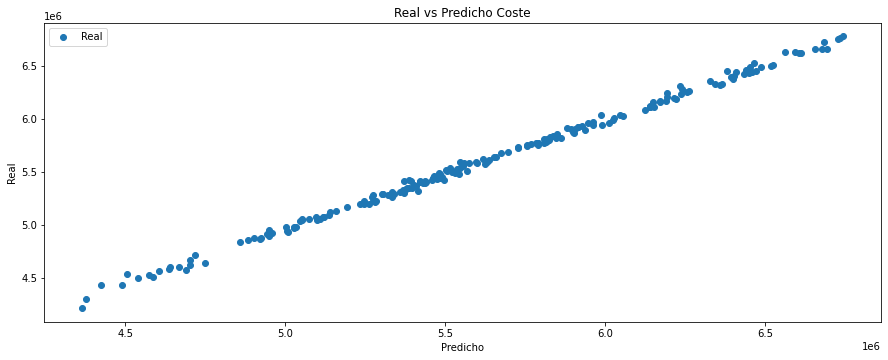

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5.5))
plt.scatter(pd_pred['Coste'].loc[0:199], pd_y_test_inverted['Coste'].loc[0:199])

plt.legend(['Real','Predicho'], loc=2)
plt.title('Real vs Predicho Coste')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.savefig('Coste.png', format='png', dpi=300)

### Esto es algo que podemos incluir en nuestro algoritmo 

Ya que mas menos tenemos idea de cuanto es nuestro resulado optimo., podriamos obtener el percentile 10 y los valores que son menores a ese percentile 10, calcular el valor exacto. El resto utilizar la red neuronal. A continuación obtenemos el percentil para las tres medicienes, coste, CO2 y energia respectivamente. 

In [ ]:
print(round(np.percentile(pred[:,0],10),0))
print(round(np.percentile(pred[:,1],10),0))
print(round(np.percentile(pred[:,2],10),0))



4933945.0
10499564.0
29994205.0
